In [1]:
import numpy as np
import torch 
import torch.nn as nn

In [2]:
import torch.optim as optim
t_c =[0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u =[35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
t_un = 0.1*t_u

n_samples = t_u.shape[0]
n_val = int(0.2*n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices
t_u.shape
t_u_train = t_u[train_indices]
t_c_train = t_c [train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c [val_indices]

t_un_train = 0.1* t_u_train
t_un_val = 0.1* t_u_val

In [3]:
linear_model=nn.Linear(1,1)
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[0.3067]], requires_grad=True)
Parameter containing:
tensor([0.4602], requires_grad=True)


In [4]:
x = torch.ones(10,1)
linear_model(x)

tensor([[0.7669],
        [0.7669],
        [0.7669],
        [0.7669],
        [0.7669],
        [0.7669],
        [0.7669],
        [0.7669],
        [0.7669],
        [0.7669]], grad_fn=<AddmmBackward0>)

In [5]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
print(list(linear_model.parameters())) # randomly set

[Parameter containing:
tensor([[-0.1678]], requires_grad=True), Parameter containing:
tensor([-0.7004], requires_grad=True)]


In [6]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train=loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training Loss {loss_train.item():.4f}, validation loss {loss_val.item():.4f}")

In [7]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) **2
    return squared_diffs.mean()

In [8]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(3000, optimizer, linear_model, loss_fn,
    t_un_train, t_un_val, t_c_train, t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training Loss 214.8884, validation loss 70.2027
Epoch 1000, Training Loss 4.8731, validation loss 2.9993
Epoch 2000, Training Loss 2.8756, validation loss 3.2651
Epoch 3000, Training Loss 2.7105, validation loss 4.5946

Parameter containing:
tensor([[5.5885]], requires_grad=True)
Parameter containing:
tensor([-18.4463], requires_grad=True)


In [9]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(3000, 
    optimizer, 
    linear_model, 
    nn.MSELoss(),
    t_un_train, t_un_val, t_c_train, t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training Loss 287.4170, validation loss 94.8472
Epoch 1000, Training Loss 4.4993, validation loss 2.6597
Epoch 2000, Training Loss 2.8447, validation loss 3.4019
Epoch 3000, Training Loss 2.7080, validation loss 4.6533

Parameter containing:
tensor([[5.5959]], requires_grad=True)
Parameter containing:
tensor([-18.4895], requires_grad=True)


In [10]:
seq_model = nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [11]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [12]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [13]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1,8)), ('hidden_activation', nn.Tanh()), ('output_linear', nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [14]:
for name, params in seq_model.named_parameters():
    print(name, param.shape)

seq_model.output_linear.bias

hidden_linear.weight torch.Size([1])
hidden_linear.bias torch.Size([1])
output_linear.weight torch.Size([1])
output_linear.bias torch.Size([1])


Parameter containing:
tensor([0.1475], requires_grad=True)

In [15]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    5000, optimizer, 
    seq_model, nn.MSELoss(),
    t_un_train, t_un_val, t_c_train, t_c_val
)
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training Loss 216.8609, validation loss 68.8591
Epoch 1000, Training Loss 4.9533, validation loss 2.6538
Epoch 2000, Training Loss 4.4016, validation loss 0.3211
Epoch 3000, Training Loss 2.7516, validation loss 1.3575
Epoch 4000, Training Loss 2.2214, validation loss 2.3160
Epoch 5000, Training Loss 2.0556, validation loss 3.2270
output tensor([[-1.6124],
        [12.8900]], grad_fn=<AddmmBackward0>)
answer tensor([[-4.],
        [11.]])
hidden tensor([[ 1.7317e-03],
        [ 3.2742e-01],
        [ 1.1823e+01],
        [ 1.1078e+01],
        [-1.1486e+01],
        [ 3.6668e-01],
        [-1.5794e-02],
        [ 1.0678e+01]])


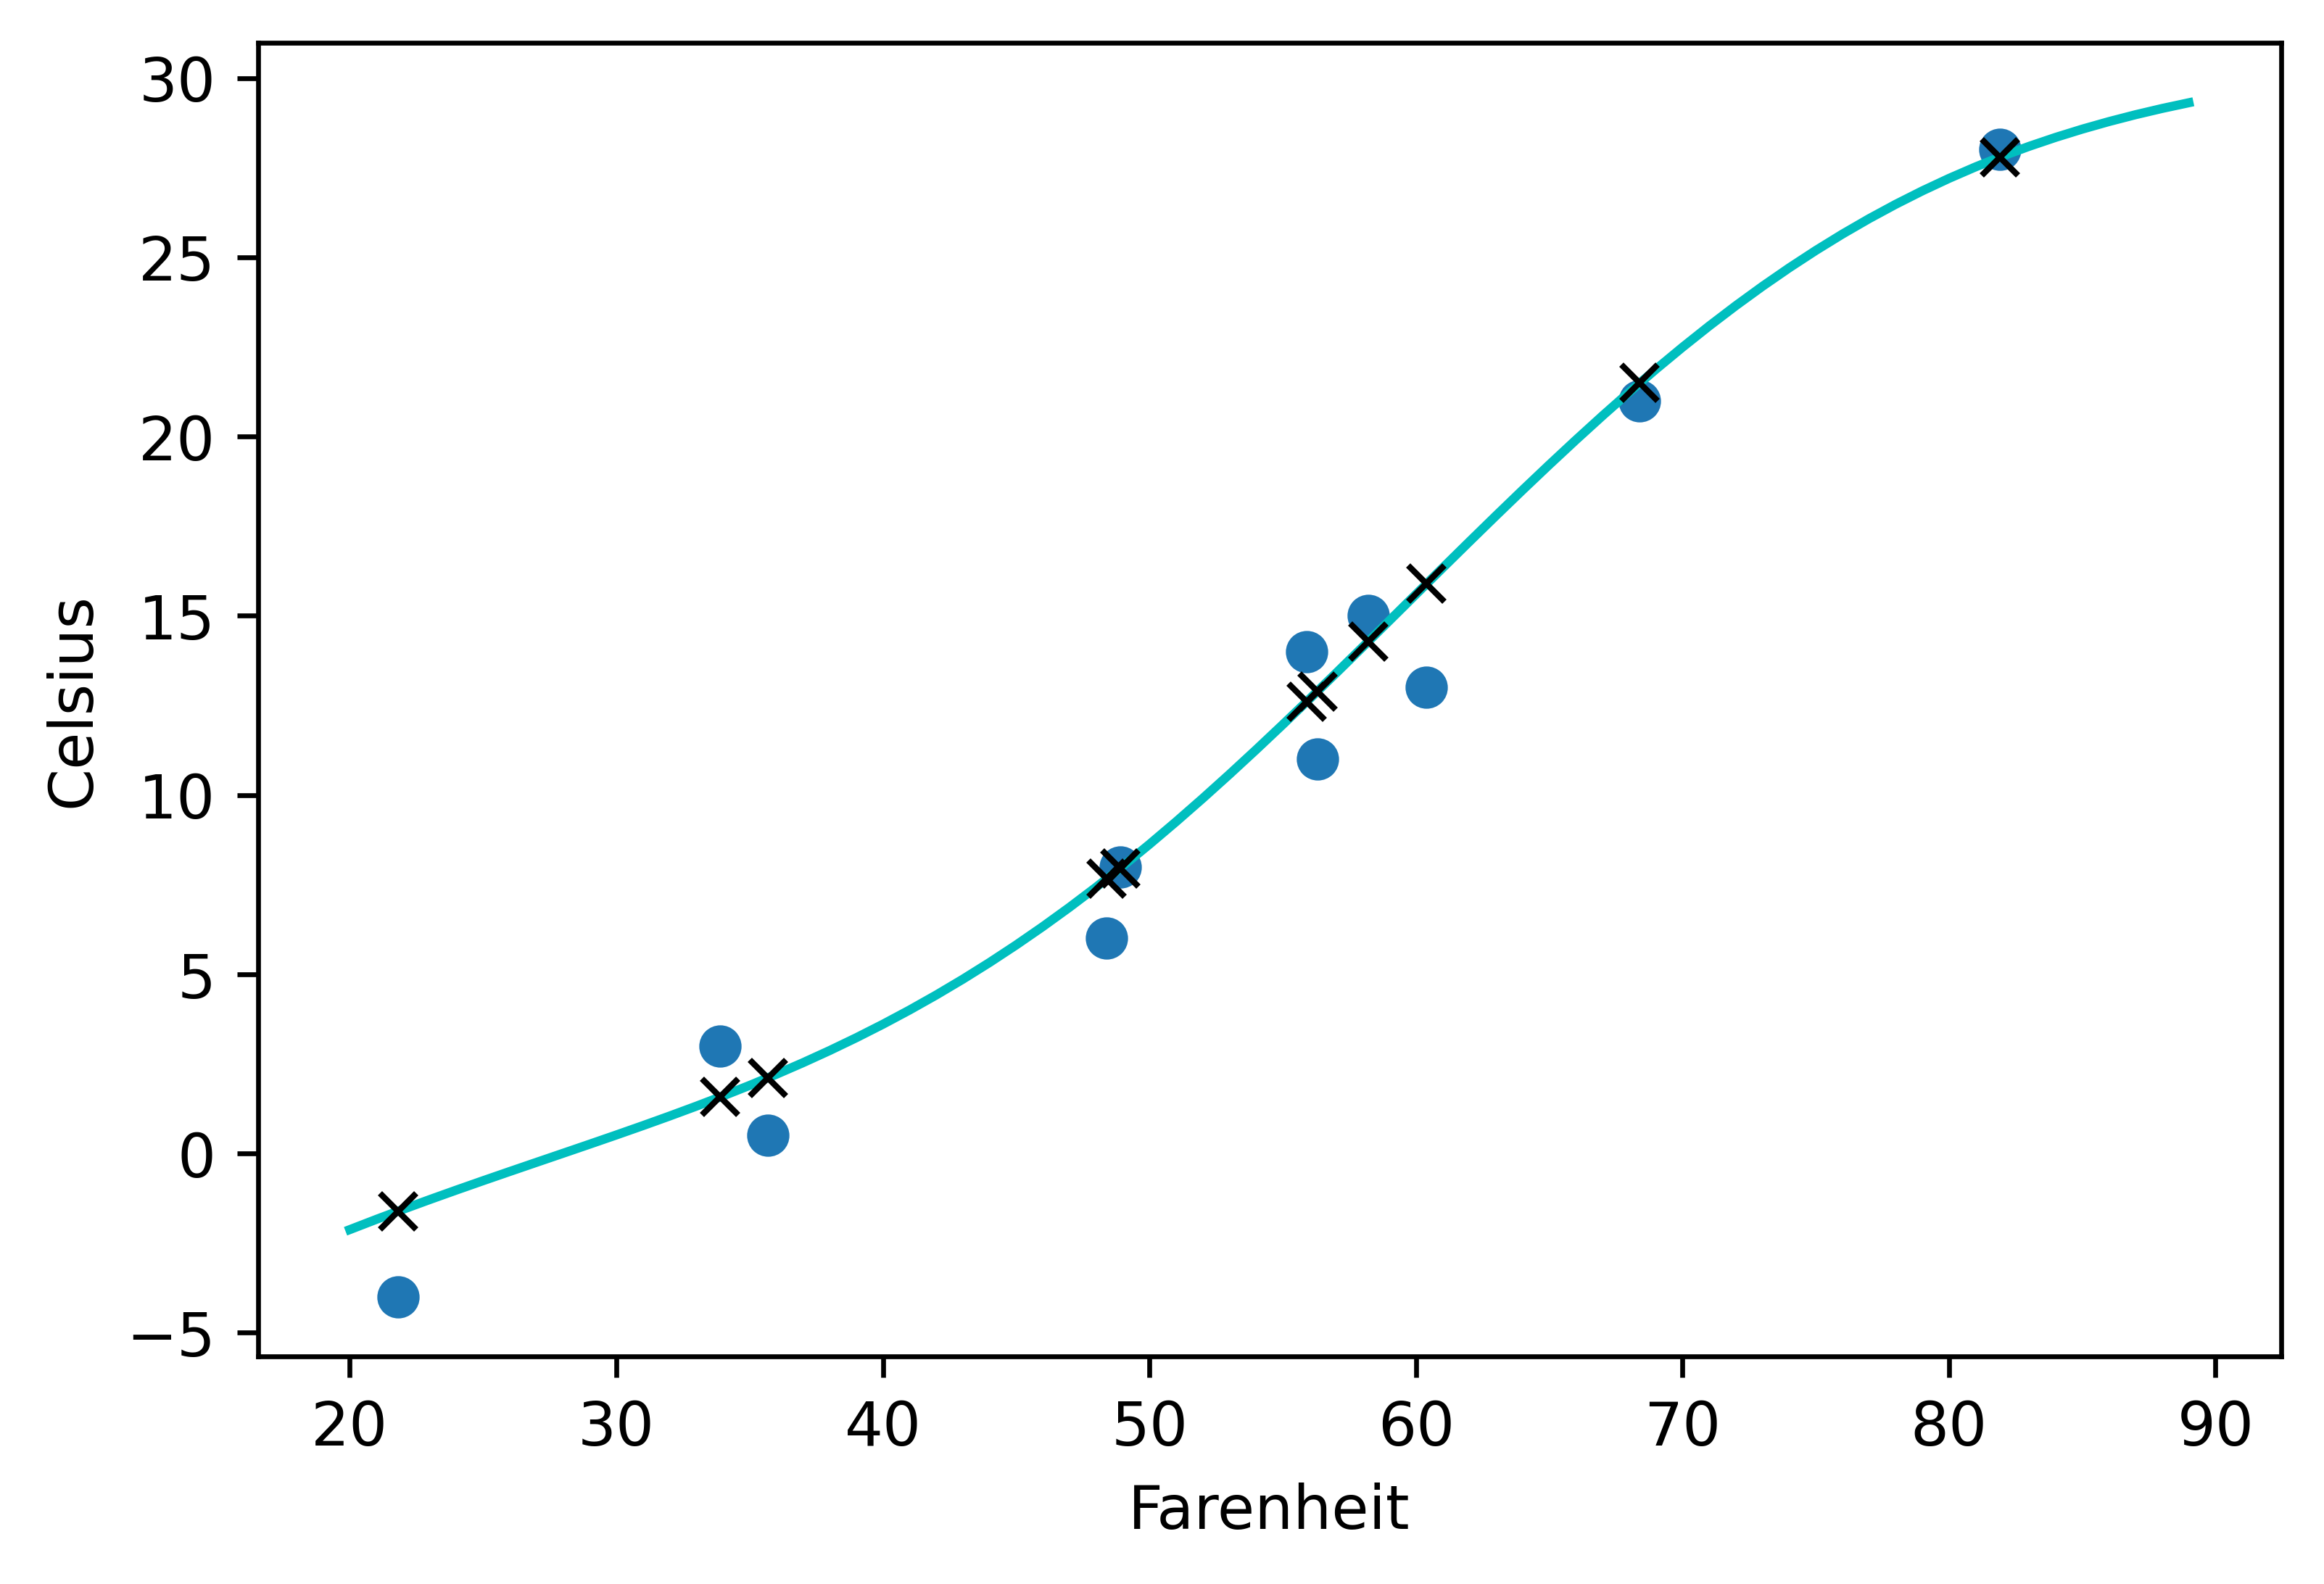

In [16]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90. ).unsqueeze(1)
fig=plt.figure(dpi=600)
plt.xlabel("Farenheit");plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach(). numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx')